In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from textblob import TextBlob
sns.set()

In [2]:
ABS_PATH = "../../data/imdb/"

# reading all the annotations

In [3]:
annotations = [i for i in os.listdir(ABS_PATH) if i.endswith('xlsx')]

In [4]:
annotations

['annotations.xlsx']

In [9]:
df = pd.DataFrame()
for path in annotations:
    df = pd.concat([df, pd.read_excel(os.path.join(ABS_PATH,path))], axis=0)

In [11]:
df = df[['image_name', 'annotation', 'human_sentiment']]

In [12]:
df.drop_duplicates(subset=['image_name'], inplace=True)

/home/volodymyr/Parallel-emotional-intent-clustering/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
display(df)

,image_name,annotation,human_sentiment
0,nm0000002_rm1447271168_1924-9-16_2004.jpg,People is enjoying the company of each other,Positive
1,nm0000002_rm1646056960_1924-9-16_1991.jpg,Woman is astonished about what she saw,Positive
2,nm0000002_rm221957120_1924-9-16_1974.jpg,Woman is astonished about what she saw,Positive
3,nm0000002_rm2805435904_1924-9-16_1988.jpg,Man is shocked because of the woman fascinatin...,Positive
4,nm0000002_rm2813958144_1924-9-16_2004.jpg,People is happy to be with each other,Positive
...,...,...,...
2175,nm0405103_rm2106164992_1990-11-24_2009.jpg,Two girls are having a good time in the bed,Positive
2176,nm1013003_rm3067652864_1973-8-3_2012.jpg,Three men are having a serious conversation,Negative
2177,nm2624602_rm3434018048_1999-5-28_2015.jpg,People is trying to pass the fence,Neutral
2178,nm0000702_rm1089766656_1976-3-22_2011.jpg,Couple is happy about something,Positive


In [14]:
df.dropna(how='any',inplace=True)

/home/volodymyr/Parallel-emotional-intent-clustering/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# analysis

In [15]:
df.shape

(2180, 3)

In [16]:
df['image_name'].nunique()

2180

In [17]:
annotations = df['annotation'].values

In [18]:
def count_unique(annotations):
    tokens, counts = np.unique(np.hstack([i.split(' ') for i in annotations]), return_counts=True)
    count_tuple = sorted(list(zip(tokens, counts)),key= lambda x: x[1])[::-1]
    return count_tuple

In [19]:
def plot_barh(entity, title=''):
    keys, values = zip(*entity[::-1])
    plt.figure(figsize=(14,12))
    plt.barh(range(len(values)), values)
    plt.yticks(range(len(values)), keys)
    plt.title(title)

In [20]:
count_tuple = count_unique([i.lower() for i in annotations])

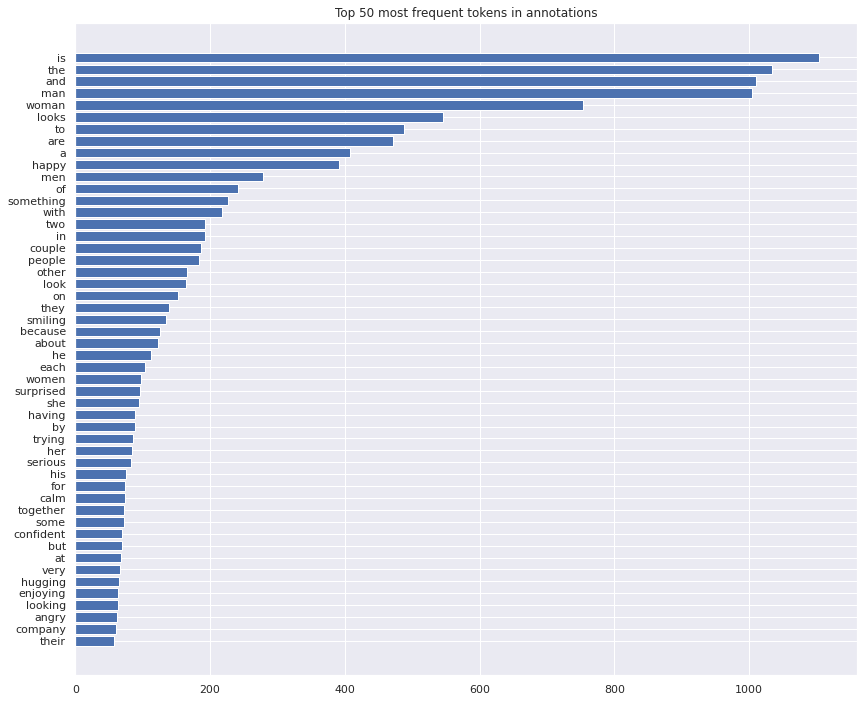

In [21]:
plot_barh(count_tuple[:50], 'Top 50 most frequent tokens in annotations')

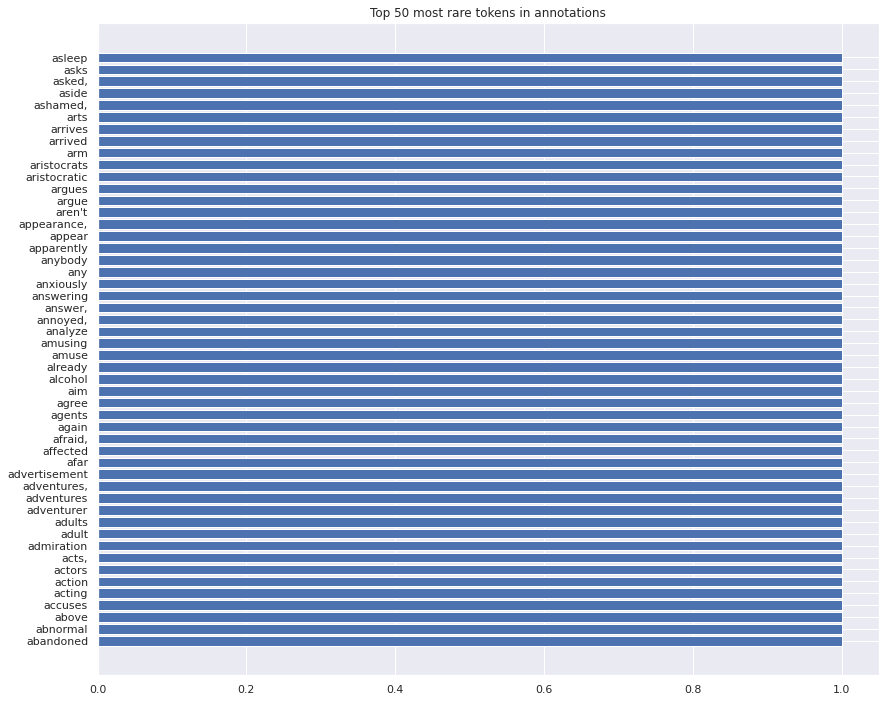

In [22]:
plot_barh(count_tuple[-50:], 'Top 50 most rare tokens in annotations')

In [23]:
len(count_tuple)

1716

In [24]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [28]:
import text2emotion as te

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
def stem(annotations):
    stemmer = PorterStemmer()
    stemmed_result = []
    stemmed_dict = {}
    for i in annotations:
        tmp = []
        for z in i.split(' '):
            tmp_stemmed = stemmer.stem(z)
            stemmed_dict.update({z:tmp_stemmed})
            tmp.append(tmp_stemmed)
        stemmed_result.append(' '.join(tmp))
    return stemmed_result, stemmed_dict

In [30]:
stemmed,stemmed_dict = stem(annotations)

In [31]:
unique_stemmed  = count_unique(stemmed)

In [32]:
len(unique_stemmed)

1392

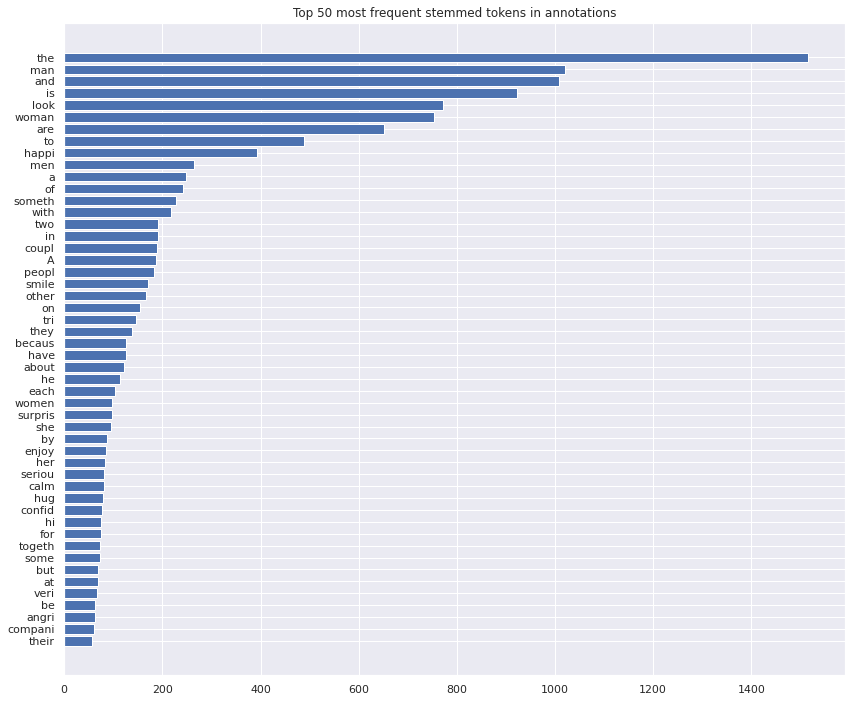

In [33]:
plot_barh(unique_stemmed[:50], 'Top 50 most frequent stemmed tokens in annotations')

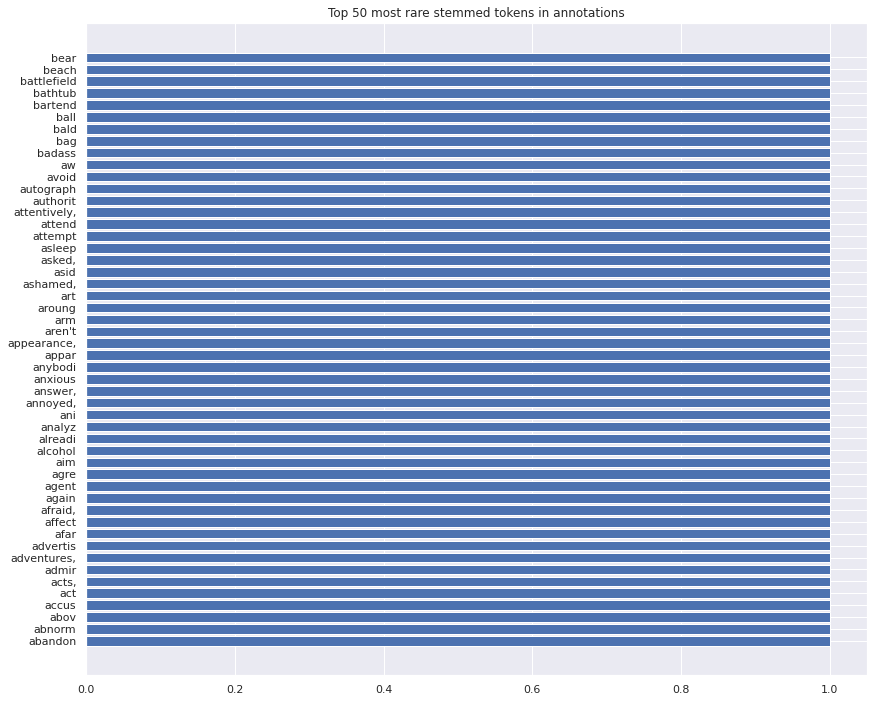

In [34]:
plot_barh(unique_stemmed[-50:], 'Top 50 most rare stemmed tokens in annotations')

# analysis in terms of sentiment

In [36]:
# import SentimentIntensityAnalyzer class 
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
  
# function to print sentiments 
# of the sentence. 
def sentiment_scores(sentence): 
    sid_obj = SentimentIntensityAnalyzer() 
    sentece = ''.join(' '+i+' ' if i in [',','.','!','?'] else i for i in sentence).strip()
    compounds = dict([(i,sid_obj.polarity_scores(i)['compound']) for i in sentence.split(' ') if sid_obj.polarity_scores(i)['compound']!=0])
    compound_score = sid_obj.polarity_scores(sentence)['compound']
    if compound_score >= 0.05 : 
        sentiment = "Positive"
  
    elif compound_score <= - 0.05 : 
        sentiment = "Negative" 
  
    else : 
        sentiment =  "Neutral" 
    return sentiment, compounds

In [37]:
sentiments = []
for i in  annotations:
    sentiments.append(sentiment_scores(i))

In [38]:
sentiment, words_compound = zip(*sentiments)

In [39]:
labels, sizes = zip(*count_unique(sentiment))

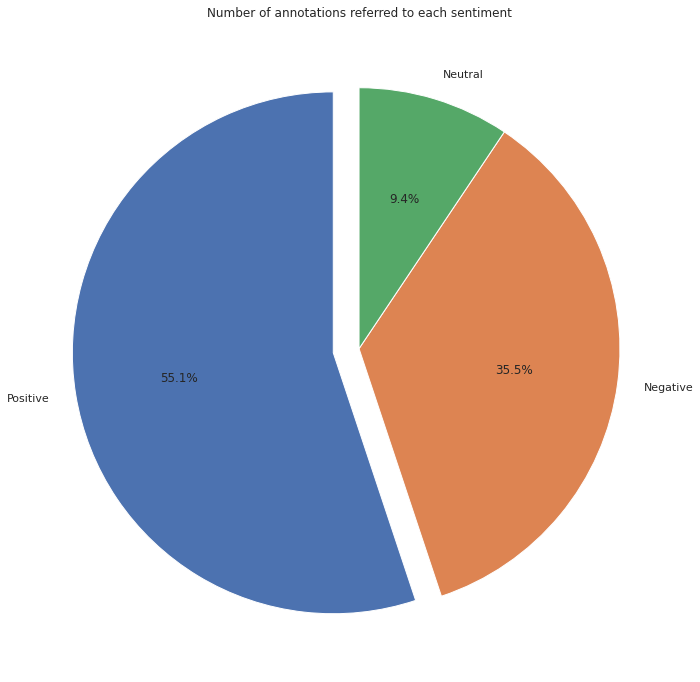

In [40]:
plt.figure(figsize=(14,12))
plt.pie(sizes, labels=labels, explode=(0.1,0,0),startangle=90,
       autopct='%1.1f%%')
plt.title('Number of annotations referred to each sentiment');

In [43]:
sentiment = np.array(sentiment)
annotations = np.array(annotations)
idx_neg = np.random.choice(np.where(sentiment=='Negative')[0], 1)
idx_pos = np.random.choice(np.where(sentiment=='Positive')[0], 1)
idx_neu = np.random.choice(np.where(sentiment=='Neutral')[0], 1)
print('Positive sentence example : {}'.format(annotations[idx_pos][0]))
print('Negative sentence example : {}'.format(annotations[idx_neg][0]))
print('Neutral sentence example : {}'.format(annotations[idx_neu][0]))

Positive sentence example : A stylish woman looks with dignity on the man in casual who is trying to explain something
Negative sentence example : A boy looks like evil genius and is selfish
Neutral sentence example : Two men discussing something


# visualizing annotations

In [44]:
from PIL import Image

In [45]:
directories = [i for i in os.listdir(ABS_PATH) if not i.endswith('csv')]

In [47]:
idx = np.random.choice(df.index,1)[0]
sampled = df.iloc[idx]
for directory in directories:
    path = os.path.join(ABS_PATH,directory)
    files = os.listdir(path)
    image = sampled['image_name']
    if image in files:
        display(Image.open(os.path.join(path, image)))
        print(sampled['annotation'])